# RAMP on predicting cyclist traffic in Paris

Authors: *Roman Yurchak (Symerio)*; also partially inspired by the air_passengers starting kit.


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Loading the data with pandas

First, download the data files,
 - [train.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/train.parquet)
 - [test.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/test.parquet)

and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [2]:
Path.cwd()

PosixPath('/Users/Quentin/Documents/GitHub/bike_counters')

In [3]:
#weather  = pd.read_csv("submissions\starting_kit\external_data.csv")

In [4]:
#weather.head

In [5]:
#weather2020 = pd.read_csv(Path("data") / "weather2020.csv")
#weather2021 = pd.read_csv(Path("data") / "weather2021.csv")

In [6]:
from vacances_scolaires_france import SchoolHolidayDates
from jours_feries_france import JoursFeries
from datetime import datetime

In [7]:
#hol = SchoolHolidayDates()
#result['hol_scol'] = result.apply(
#    lambda row: hol.is_holiday_for_zone(datetime.strptime(row["date"],'%Y-%m-%d').date(), 'C'), axis=1)
#result['hol_bank'] = result.apply(
#    lambda row: JoursFeries.is_bank_holiday(datetime.strptime(row["date"],'%Y-%m-%d').date(), zone="Métropole"), axis=1)



In [8]:
#result.head()

In [9]:
#result.to_csv(Path("data") / "weather_new_hol.csv")

In [10]:
data = pd.read_csv(Path("data") / "external_data.csv")

In [11]:
from vacances_scolaires_france import SchoolHolidayDates
from jours_feries_france import JoursFeries
from datetime import datetime

In [12]:
hol = SchoolHolidayDates()
data['hol_scol'] = data.apply(
    lambda row: hol.is_holiday_for_zone(datetime.strptime(row["date"],'%Y-%m-%d %H:%M:%S').date(), 'C'), axis=1)
data['hol_bank'] = data.apply(
    lambda row: JoursFeries.is_bank_holiday(datetime.strptime(row["date"],'%Y-%m-%d %H:%M:%S').date(), zone="Métropole"), axis=1)

In [13]:
pd.DataFrame.to_csv(data, Path("data") / "external_data.csv")

In [14]:
data = pd.read_csv(Path("data") / "external_data.csv")
data["quarantine1"] = np.where((data["date"]<= "2020-12-15") & (data["date"] >= "2020-10-30"), "True", "False")
data["quarantine2"] = np.where((data["date"]<= "2021-05-03") & (data["date"] >= "2021-04-03"), "True", "False")
pd.DataFrame.to_csv(data, Path("data") / "external_data.csv")

In [15]:
data.columns


Index(['Unnamed: 0', 'numer_sta', 'date', 'pmer', 'tend', 'cod_tend', 'dd',
       'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl',
       'cm', 'ch', 'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12',
       'tx24', 'tminsol', 'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol',
       'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24',
       'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1',
       'hnuage1', 'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3',
       'hnuage3', 'nnuage4', 'ctype4', 'hnuage4', 'hol_scol', 'hol_bank',
       'quarantine1', 'quarantine2'],
      dtype='object')

In [16]:
data[data["date"] == "2020-11-11 00:00:00"]
#data.loc[data['date'] == 'yellow']
#data.head()

,Unnamed: 0,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,...,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,hol_scol,hol_bank,quarantine1,quarantine2
1939,1939,7149,2020-11-11 00:00:00,102700,-30,6,190,2.0,284.95,284.35,...,7.0,6.0,660.0,NaN,NaN,NaN,False,True,True,False


In [17]:
data.head()

,Unnamed: 0,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,...,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,hol_scol,hol_bank,quarantine1,quarantine2
0,0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,False
1,1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,False
2,2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,...,6.0,3.0,3000.0,NaN,NaN,NaN,True,True,False,False
3,3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,False
4,4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,...,7.0,6.0,810.0,NaN,NaN,NaN,True,True,False,False


In [18]:
import matplotlib.pyplot as plt

In [19]:
pd.date_range(start = '2020-09-01', end = '2021-10-18' ).difference(data["date"]) #2020-09-01 01:00:00 a2021-10-18 21:00:00

DatetimeIndex(['2021-01-17'], dtype='datetime64[ns]', freq=None)

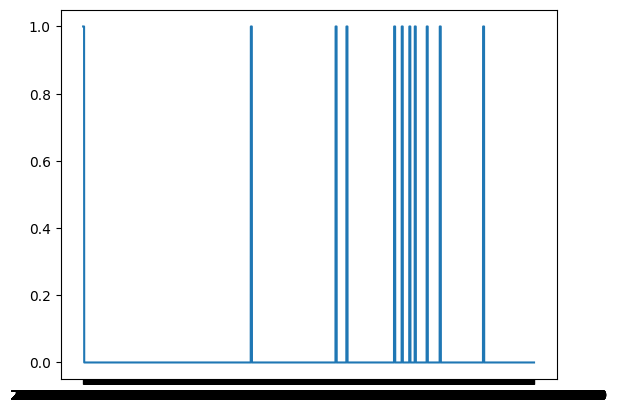

In [20]:
plt.plot(data["date"],data["hol_bank"])

In [21]:
#data.to_csv(Path("data") / "weather_hol.csv")

In [22]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [23]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns,

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

and in particular the number of unique entries in each column,

In [25]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    977
date                         8230
counter_installation_date      22
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                977
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations,

In [26]:
data.groupby(["site_name", "counter_name"])["bike_count"].sum().sort_values(
    ascending=False
).head(10).to_frame()

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1809231.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1406900.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1357868.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1036575.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,914089.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,888717.0
Quai d'Orsay,Quai d'Orsay E-O,849724.0
Totem Cours la Reine,Totem Cours la Reine O-E,806149.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,806071.0


# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [27]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

Note that in this RAMP problem we consider only the 30 most frequented counting sites, to limit data size.


Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points,

In [ ]:
print(data["counter_name"].unique())

<AxesSubplot: xlabel='date'>

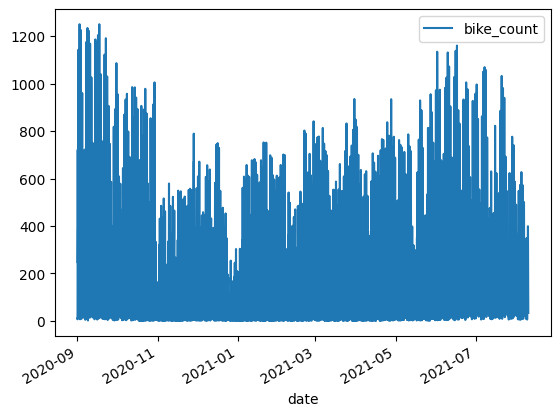

In [28]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

Instead we aggregate the data, for instance, by week to have a clearer overall picture,

<AxesSubplot: xlabel='date'>

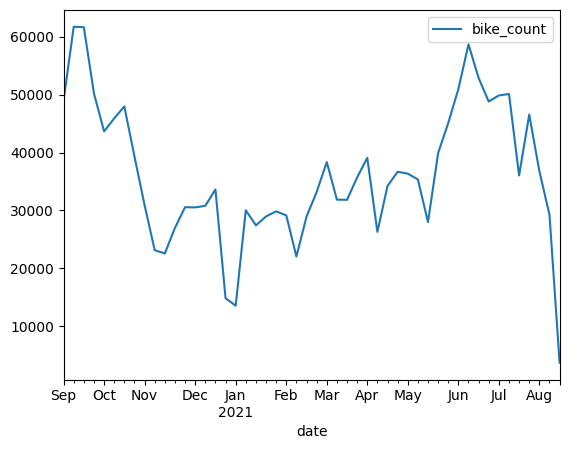

In [29]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization,

<AxesSubplot: xlabel='date'>

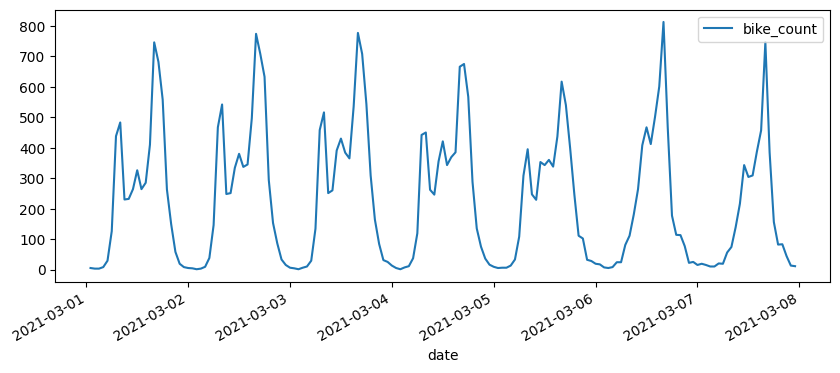

In [30]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

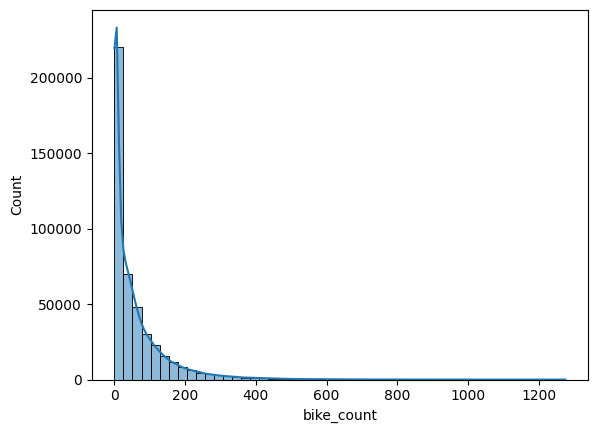

In [31]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

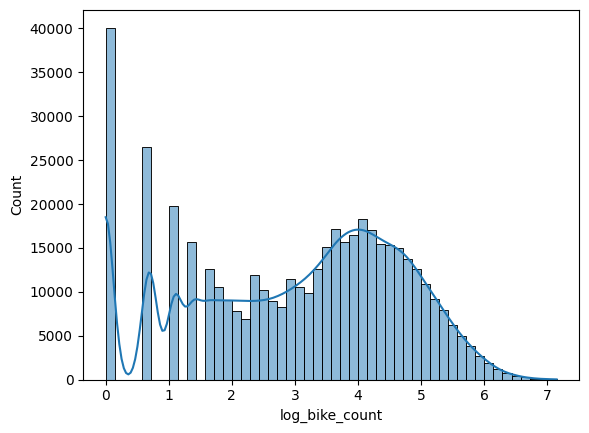

In [32]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field, 

In [33]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    X.loc[:, "day_of_the_year"] = X["date"].dt.day  # 2020 366
    X['sin_day_of_the_year'] = np.sin(2*np.pi*X["day_of_the_year"]/366)
    X['cos_day_of_the_year'] = np.cos(2*np.pi*X["day_of_the_year"]/366)

    X['sin_hours'] = np.sin(2*np.pi*X["hour"]/24)
    X['cos_hours'] = np.cos(2*np.pi*X["hour"]/24)
    # X.drop('hour', axis=1, inplace=True)

    # check si je peux enlever
    X['sin_weekday'] = np.sin(2*np.pi*X["weekday"]/7)
    X['cos_weekday'] = np.cos(2*np.pi*X["weekday"]/7)
    # X.drop('weekday', axis=1, inplace=True)

    X['sin_mnth'] = np.sin(2*np.pi*X["month"]/12)
    X['cos_mnth'] = np.cos(2*np.pi*X["month"]/12)
    # X.drop('month', axis=1, inplace=True)

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [34]:
data["date"].head()

48321   2020-09-01 02:00:00
48324   2020-09-01 03:00:00
48327   2020-09-01 04:00:00
48330   2020-09-01 15:00:00
48333   2020-09-01 18:00:00
Name: date, dtype: datetime64[ns]

In [35]:
_encode_dates(data[["date"]].head())

,year,month,day,weekday,hour,day_of_the_year,sin_day_of_the_year,cos_day_of_the_year,sin_hours,cos_hours,sin_weekday,cos_weekday,sin_mnth,cos_mnth
48321,2020,9,1,1,2,1,0.017166,0.999853,0.500000,8.660254e-01,0.781831,0.62349,-1.0,-1.836970e-16
48324,2020,9,1,1,3,1,0.017166,0.999853,0.707107,7.071068e-01,0.781831,0.62349,-1.0,-1.836970e-16
48327,2020,9,1,1,4,1,0.017166,0.999853,0.866025,5.000000e-01,0.781831,0.62349,-1.0,-1.836970e-16
48330,2020,9,1,1,15,1,0.017166,0.999853,-0.707107,-7.071068e-01,0.781831,0.62349,-1.0,-1.836970e-16
48333,2020,9,1,1,18,1,0.017166,0.999853,-1.000000,-1.836970e-16,0.781831,0.62349,-1.0,-1.836970e-16


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html),

In [36]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(data[["date"]]).head()

,year,month,day,weekday,hour,day_of_the_year,sin_day_of_the_year,cos_day_of_the_year,sin_hours,cos_hours,sin_weekday,cos_weekday,sin_mnth,cos_mnth
48321,2020,9,1,1,2,1,0.017166,0.999853,0.500000,8.660254e-01,0.781831,0.62349,-1.0,-1.836970e-16
48324,2020,9,1,1,3,1,0.017166,0.999853,0.707107,7.071068e-01,0.781831,0.62349,-1.0,-1.836970e-16
48327,2020,9,1,1,4,1,0.017166,0.999853,0.866025,5.000000e-01,0.781831,0.62349,-1.0,-1.836970e-16
48330,2020,9,1,1,15,1,0.017166,0.999853,-0.707107,-7.071068e-01,0.781831,0.62349,-1.0,-1.836970e-16
48333,2020,9,1,1,18,1,0.017166,0.999853,-1.000000,-1.836970e-16,0.781831,0.62349,-1.0,-1.836970e-16


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [37]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

enc.fit_transform(_encode_dates(data[["date"]])[["year"]].head())

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `problem.py` of the starting kit to load the public train and test data:

In [38]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [39]:
X_train.head(2)

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233


and

In [40]:
y_train

array([1.60943791, 1.38629436, 0.        , ..., 2.48490665, 1.60943791,
       1.38629436])

Where `y` contains the `log_bike_count` variable. 

The test set is in the future as compared to the train set,

In [41]:
print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Test: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}'
)

Train: n_samples=455163,  2020-09-01 01:00:00 to 2021-08-09 23:00:00
Test: n_samples=41608,  2021-08-10 01:00:00 to 2021-09-09 23:00:00


In [42]:
_encode_dates(X_train[["date"]]).columns.tolist()

['year',
 'month',
 'day',
 'weekday',
 'hour',
 'day_of_the_year',
 'sin_day_of_the_year',
 'cos_day_of_the_year',
 'sin_hours',
 'cos_hours',
 'sin_weekday',
 'cos_weekday',
 'sin_mnth',
 'cos_mnth']

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

date_encoder = FunctionTransformer(_encode_dates)

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name",
                    "year", "day", "hour", "weekday", "month"]  # "holiday"]

# numerical_cols = ["latitude", "longitude"] #not helping

pass_through_cols = ["sin_hours", "cos_hours", "sin_mnth", "cos_mnth",
                     "sin_day_of_the_year", "cos_day_of_the_year"]

preprocessor = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_cols),
        # ("std_scaler", StandardScaler(), numerical_cols),
        ("passthrough", "passthrough", pass_through_cols)
    ],
)

parameters = { 'nthread': [4],  # when use hyperthread, xgboost may become slower
    'n_estimators': [75, 100, 200],#200
    'max_depth': [3, 5, 7],  #6
    'min_child_weight': [0.5, 1, 4],
    'learning_rate': [.02, 0.03, .05],  # so called `eta` value
    'min_split_loss': [0, 1, 3, 5],  # so called `gamma` value
    'colsample_bytree': [0.6, 0.75, 1],
    'subsample': [0.6, 0.75, 1]}

regressor = XGBRegressor()

xgb_grid = GridSearchCV(regressor,
                        parameters,
                        cv=2,
                        n_jobs=5,
                        verbose=True)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
    
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7fe3d667f280>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'year', 'day', 'hour',
                                                   'weekday', 'month']),
                                                 ('passthrough', 'passthrough',
                                                  ['sin_hours', 'cos_hours',
                                                   'sin_mnth', 'cos_mnth',
                                                   '...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

In [46]:
#print(pipe.named_steps['gridsearchcv'].best_score_)
#print(pipe.named_steps['gridsearchcv'].best_params_)

In [47]:
#print(pd.DataFrame(pipe.named_steps['xgb_grid'].cv_results_))

In [48]:
#print(len(pipe.named_steps['ridge'].coef_))

We then evaluate this model with the RMSE metric,

In [49]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}"
)

Train set, RMSE=0.43
Test set, RMSE=0.46


Train set, RMSE=0.61
Test set, RMSE=0.59 NN

Train set, RMSE=0.80
Test set, RMSE=0.73

The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [50]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, np.full(y_test.shape, y_test.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.68
Test set, RMSE=1.44


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations,

In [51]:
mask = (
    (X_test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_test["date"] > pd.to_datetime("2021/09/01"))
    & (X_test["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_test.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

Text(0, 0.5, 'bike_count')

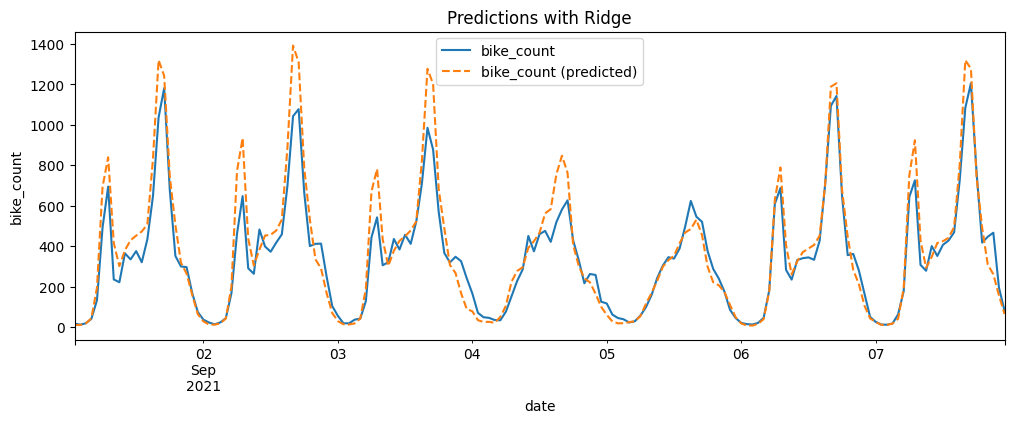

In [52]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

<AxesSubplot: xlabel='y_true', ylabel='y_pred'>

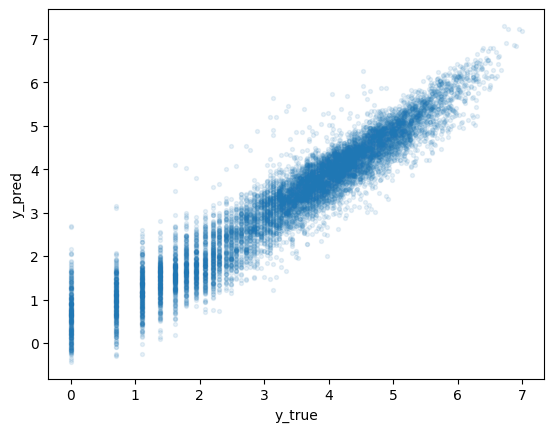

In [53]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_test, "y_pred": pipe.predict(X_test)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html),

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores, 

In [54]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.79156979 -0.71766819 -0.73693833 -0.76360466 -0.71851381 -0.75458828]
RMSE (all folds): 0.747 ± 0.0261
